# Лабораторная работа №1

Гилемханов Дмитрий Сергеевич, J4251

### 1. Загрузка и предобработка данных
Загрузим координаты скважин и историю добычи

In [1]:
import warnings

warnings.filterwarnings("ignore")

from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import Voronoi
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

pd.set_option("display.max_columns", None)
pd.options.display.max_colwidth = 250
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [2]:
ROOT_DIR = Path(".").resolve().parent
DATA_PATH = ROOT_DIR / "task0" / "example" / "hw"

coords_df = pd.read_csv(DATA_PATH / "coords.csv")
train_df = pd.read_csv(DATA_PATH / "train.csv")

train_df["date"] = pd.to_datetime(train_df["date"])
train_df["cat"] = train_df["cat"].str.lower()
coords_df["cat"] = coords_df["cat"].str.lower()

df = train_df[train_df["group"] == "P"].copy()

print(f"Уникальных добывающих скважин: {df['cat'].nunique()}")
df.head()

Уникальных добывающих скважин: 265


,cat,date,gor,gas,oil,watercut,water,bhp,group,water_inj
0,hw-3,2020-02-01,731.41,3660375.42,5004.51,0.00,0.00,3274.06,P,NaN
1,hw-3,2020-03-01,731.41,3782298.54,5171.21,0.00,0.00,3237.29,P,NaN
2,hw-3,2020-04-01,731.41,3571576.79,4883.11,0.00,0.00,3221.12,P,NaN
3,hw-3,2020-05-01,731.41,3653934.82,4995.71,0.00,0.00,3196.40,P,NaN
4,hw-3,2020-06-01,731.41,3611093.24,4937.13,0.00,0.00,3187.04,P,NaN


### 2. Подготовка временных рядов
Преобразуем данные в pivot table

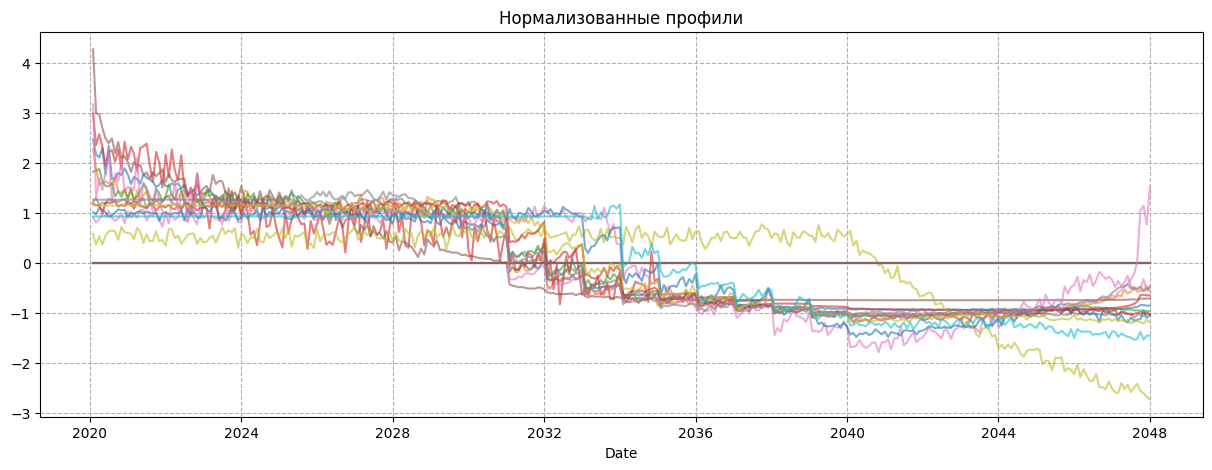

In [3]:
column_to_clust = "oil"

data_pivot = df.pivot_table(index="date", columns="cat", values=column_to_clust)

data_pivot = data_pivot.bfill().ffill().fillna(0)

scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(data_pivot),
    index=data_pivot.index,
    columns=data_pivot.columns,
)

plt.figure(figsize=(15, 5))
plt.title("Нормализованные профили")
for col in data_scaled.columns[:20]:
    plt.plot(data_scaled.index, data_scaled[col], alpha=0.6)
plt.xlabel("Date")
plt.grid(ls="--")
plt.show()

### 3. Иерархический анализ

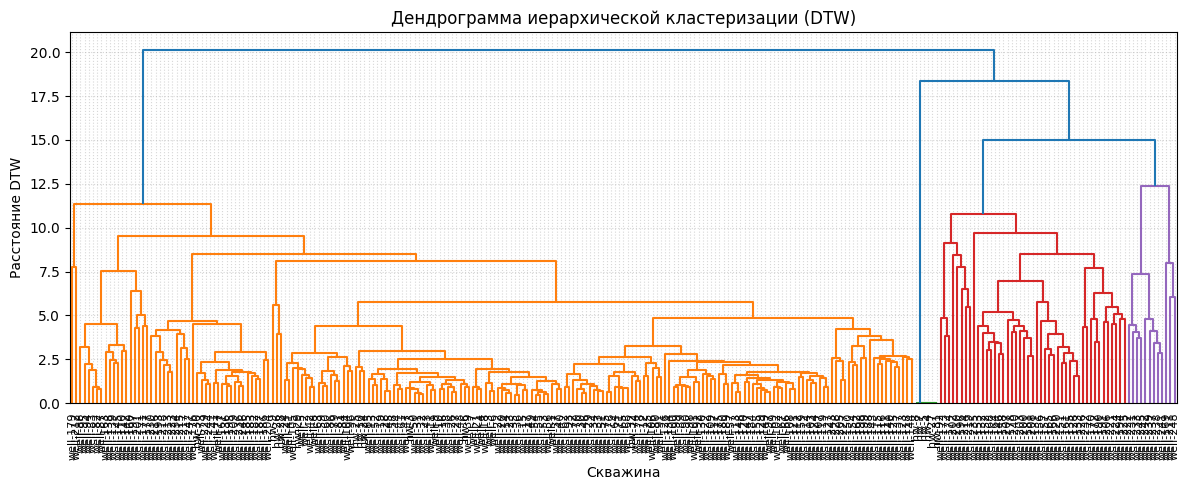

In [4]:
distances = pdist(data_scaled.T, metric=dtw)

links = linkage(distances, method="average")

plt.figure(figsize=(12, 5))
plt.title("Дендрограмма иерархической кластеризации (DTW)")
plt.xlabel("Скважина")
plt.ylabel("Расстояние DTW")

dendrogram(
    links,
    labels=data_scaled.columns,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=None,
)
plt.grid(ls=":", alpha=0.5)
plt.tight_layout()
plt.show()

### 4. Поиск оптимального числа кластеров

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:27<00:00, 51.90s/it]


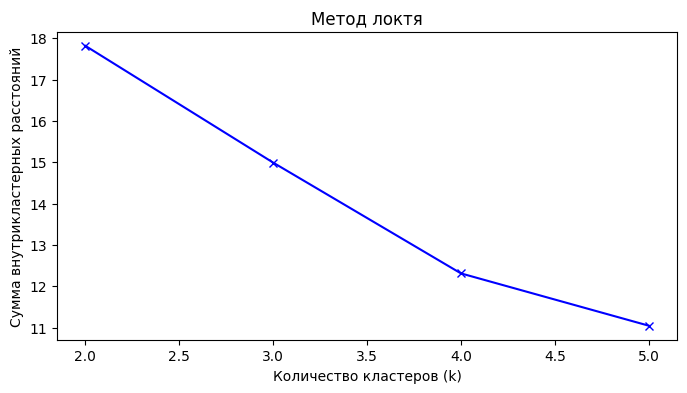

In [5]:
_distortions = []
n_ran = range(2, 6)

for _k in tqdm.tqdm(n_ran):
    model = TimeSeriesKMeans(
        n_clusters=_k, metric="dtw", max_iter=10, random_state=42, n_jobs=-1
    )
    model.fit(data_scaled.T)
    _distortions.append(model.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(n_ran, _distortions, "bx-")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Сумма внутрикластерных расстояний")
plt.title("Метод локтя")
plt.show()

Дополнительно проверим качество разбиения с помощью коэффициента силуэта

Calculating metrics: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:26<00:00, 51.50s/it]


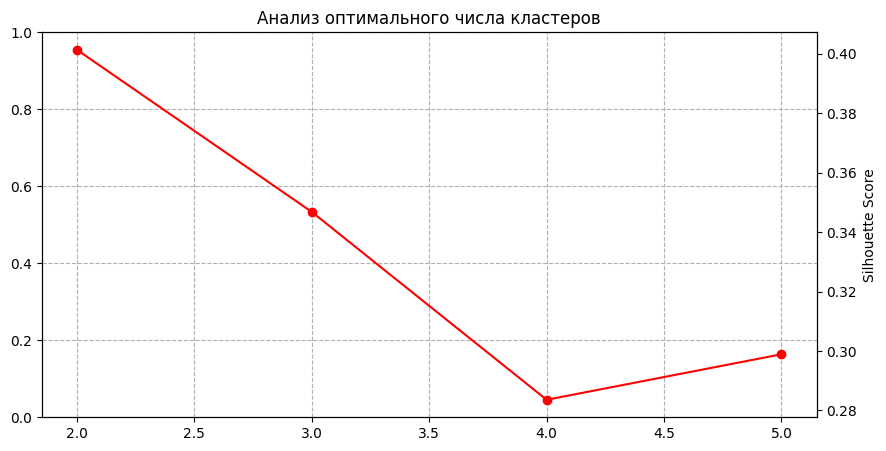

Оптимальное количество кластеров по коэффициенту силуэта: 2


In [6]:
silhouette_values = []
n_range = range(2, 6)
for k in tqdm.tqdm(n_range, desc="Calculating metrics"):
    _model = TimeSeriesKMeans(
        n_clusters=k, metric="dtw", max_iter=10, random_state=42, n_jobs=-1
    )
    labels = _model.fit_predict(data_scaled.T)
    score = silhouette_score(data_scaled.T, labels)
    silhouette_values.append(score)

_fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax2.plot(n_range, silhouette_values, "ro-", label="Silhouette Score")
ax2.set_ylabel("Silhouette Score")
ax2.tick_params(axis="y")
plt.title("Анализ оптимального числа кластеров")
ax1.grid(ls="--")
plt.show()

best_k = int(n_range[np.argmax(silhouette_values)])
print(f"Оптимальное количество кластеров по коэффициенту силуэта: {best_k}")

### 5. Финальная кластеризация
Применим модель `TimeSeriesKMeans` с оптимальным числом кластеров и сопоставим полученные метки с координатами скважин.

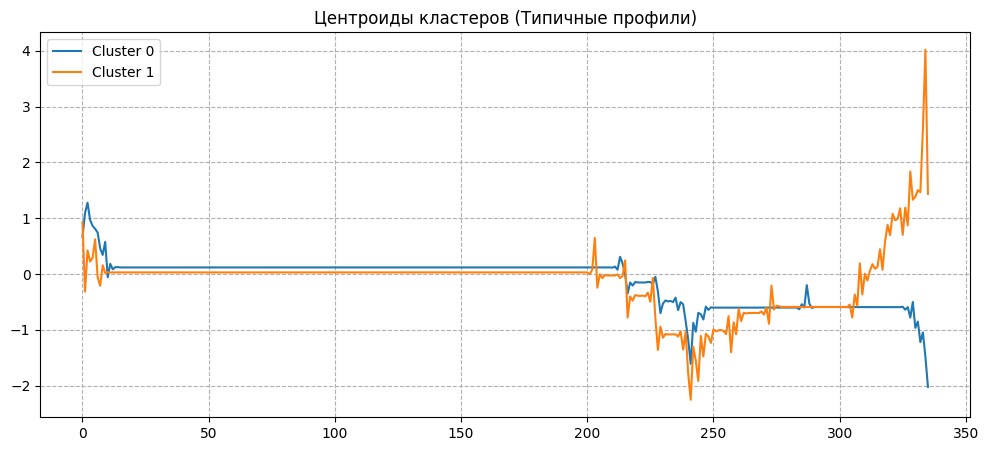

In [7]:
n_clusters = best_k
final_model = TimeSeriesKMeans(
    n_clusters=n_clusters, metric="dtw", n_jobs=-1, max_iter=100, random_state=42
)
_clusters = final_model.fit_predict(data_scaled.T)

plt.figure(figsize=(12, 5))
for i in range(n_clusters):
    plt.plot(final_model.cluster_centers_[i].ravel(), label=f"Cluster {i}")
plt.title("Центроиды кластеров (Типичные профили)")
plt.legend()
plt.grid(ls="--")
plt.show()

well_to_cluster = dict(zip(data_scaled.columns, _clusters))

coords_clustered_df = coords_df.copy()
coords_clustered_df["cluster"] = coords_clustered_df["cat"].map(well_to_cluster)

### 6. Визуализация

In [8]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite Voronoi regions in a 2D diagram to finite regions.
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = np.ptp(vor.points, axis=0).max() * 2

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [9]:
def draw_map(points, clusters):
    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)

    cmap = plt.get_cmap("tab10")

    _fig, ax = plt.subplots(figsize=(12, 10))

    for i, region in enumerate(regions):
        polygon = vertices[region]
        cluster_id = int(clusters[i])

        if cluster_id == 0:
            color = "orange"
        elif cluster_id == 1:
            color = "green"
        else:
            color = cmap(cluster_id % 10)

        ax.fill(
            *zip(*polygon), alpha=0.4, color=color, edgecolor="black", linewidth=0.6
        )

    scatter = ax.scatter(
        points[:, 0],
        points[:, 1],
        c=clusters,
        cmap="tab10",
        edgecolors="black",
        s=10,
        zorder=5,
    )

    ax.set_title("Карта кластеров скважин")
    ax.set_xlabel("X, м")
    ax.set_ylabel("Y, м")
    ax.set_aspect("equal")
    plt.grid(ls=":", alpha=0.3)

    x_min, x_max = np.percentile(points[:, 0], [1, 98])
    y_min, y_max = np.percentile(points[:, 1], [1, 98])
    margin = 0.1 * (x_max - x_min)
    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)

    plt.show()

Отобразим полученные кластеры на карте месторождения:

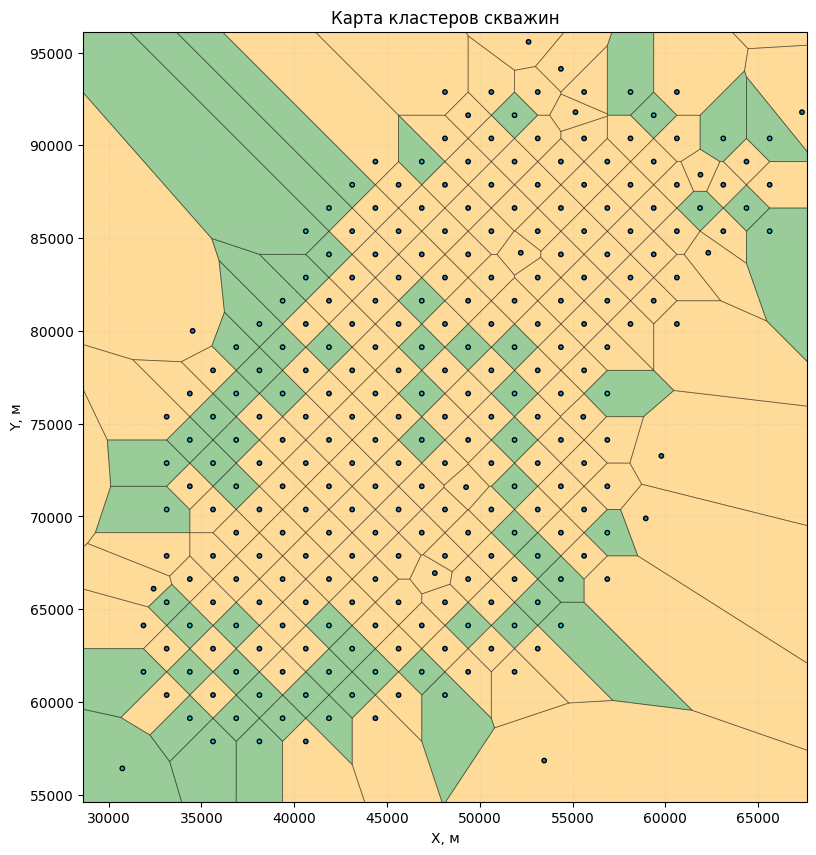

In [10]:
coords_clean = coords_clustered_df.dropna(subset=["cluster"])

points = coords_clean[["x", "y"]].values
_clusters = coords_clean["cluster"].values.astype(int)

draw_map(points, _clusters)

### Вывод

В ходе работы выполнена кластеризация динамики добычи нефти с использованием алгоритма TimeSeriesKMeans.

Анализ дендрограммы показал естественное разделение скважин на крупные группы, что подтвердило результаты анализа метрики силуэта: оптимальным является разделение два основных кластеры.

Визуализация результатов через диаграмму Вороного выявила явную пространственную зависимость распределения классов. Основная территория месторождения занята скважинами нулевого кластера, что говорит о схожести геологических условий или применяемых технологий разработки в этой зоне, тогда как второй кластер имеет иную локализацию.